# 4 Setting the initial SoC

Setting the initial SoC for your pack is performed with an argument passed to the solve algorithm. Currently the same value is applied to each battery but in future it will be possible to vary the SoC across the pack.

In [1]:
import liionpack as lp
import pybamm
import numpy as np
import matplotlib.pyplot as plt

c:\users\tom\code\pybamm\pybamm\expression_tree\functions.py:204: RuntimeWarning: invalid value encountered in sign
  return self.function(*evaluated_children)


Lets set up the most simple pack possible with 1 battery and very low busbar resistance to compare to a pure PyBaMM simulation

In [2]:
Rsmall = 1e-6

In [3]:
netlist = lp.setup_circuit(Np=1, Ns=1, Rb=Rsmall, Rc=Rsmall, Ri=5e-2, V=4.0, I=1.0)

In [4]:
# Heat transfer coefficients
htc = np.ones(1) * 10
# PyBaMM parameters
chemistry = pybamm.parameter_sets.Chen2020
parameter_values = pybamm.ParameterValues(chemistry=chemistry)

In [5]:
# Cycling experiment
experiment = pybamm.Experiment(
    [
        (
            "Discharge at 1 A for 1000 s or until 3.3 V",
            "Rest for 1000 s",
            "Charge at 1 A for 1000 s or until 4.0 V",
            "Rest for 1000 s",
        )
    ]
    * 3, period="10 s"
)

In [6]:
SoC = 0.5

In [7]:
# Solve pack
output = lp.solve(netlist=netlist,
                  parameter_values=parameter_values,
                  experiment=experiment,
                  htc=htc, initial_soc=SoC)

c:\users\tom\code\pybamm\pybamm\expression_tree\functions.py:204: RuntimeWarning: invalid value encountered in sign
  return self.function(*evaluated_children)
Solving Pack: 100%|███████████████████████████████████████████████████████████████| 1200/1200 [00:06<00:00, 188.26it/s]


Let's compare to the PyBaMM simulation

In [8]:
parameter_values = pybamm.ParameterValues(chemistry=chemistry)
parameter_values.update({"Total heat transfer coefficient [W.m-2.K-1]": 10.0})
sim = lp.create_simulation(parameter_values, experiment, make_inputs=False)

In [9]:
sol = sim.solve(initial_soc=SoC)

In [10]:
def compare(sol, output):
    # Get pack level results
    time = sol["Time [s]"].entries
    v_pack = output["Pack terminal voltage [V]"]
    i_pack = output["Pack current [A]"]
    v_batt = sol["Terminal voltage [V]"].entries
    i_batt = sol["Current [A]"].entries

    # Plot pack voltage and current
    _, (axl, axr) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 10), sharex=True, sharey=True)
    axl.plot(time[1:], v_pack, color="green", label="simulation")
    axl.set_xlabel("Time [s]")
    axl.set_ylabel("Pack terminal voltage [V]", color="green")
    axl2 = axl.twinx()
    axl2.plot(time[1:], i_pack, color="black", label="simulation")
    axl2.set_ylabel("Pack current [A]", color="black")
    axl2.set_title("Liionpack Simulation")
    axr.plot(time, v_batt, color="red", label="simulation")
    axr.set_xlabel("Time [s]")
    axr.set_ylabel("Battery terminal voltage [V]", color="red")
    axr2 = axr.twinx()
    axr2.plot(time, i_batt, color="blue", label="simulation")
    axr2.set_ylabel("Battery current [A]", color="blue")
    axr2.set_title("Single PyBaMM Simulation")

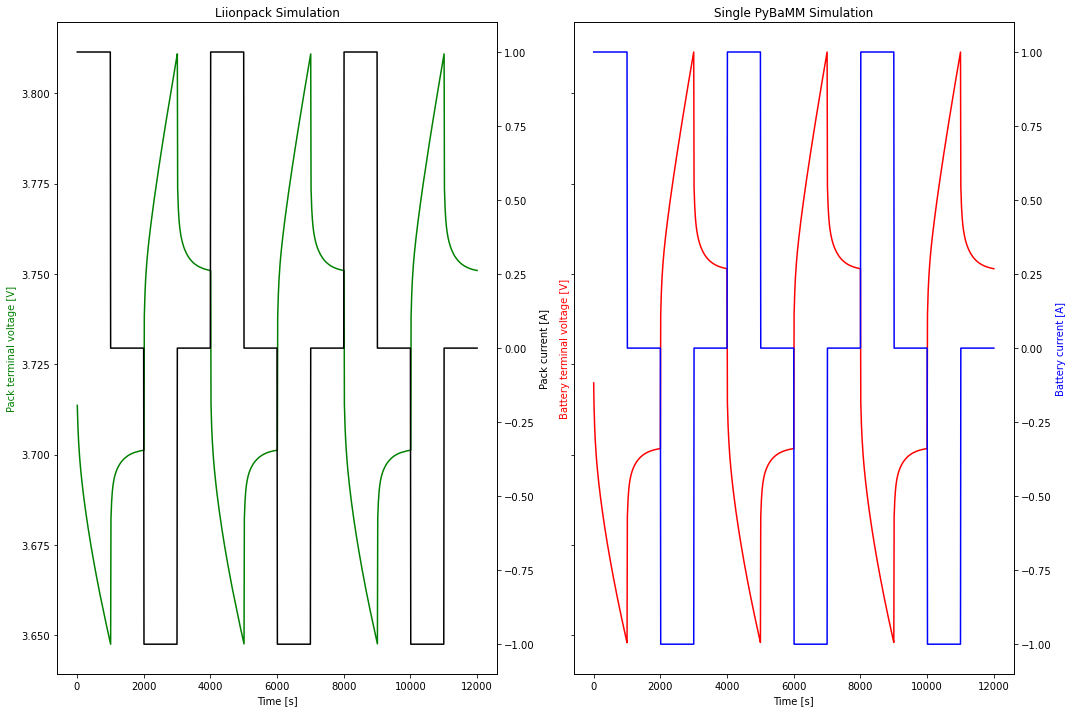

In [11]:
compare(sol, output)

Now lets start the simulation from a different state of charge

In [12]:
SoC = 0.25

In [13]:
# Solve pack
output = lp.solve(netlist=netlist,
                  parameter_values=parameter_values,
                  experiment=experiment,
                  htc=htc, initial_soc=SoC)

Solving Pack: 100%|███████████████████████████████████████████████████████████████| 1200/1200 [00:06<00:00, 186.57it/s]


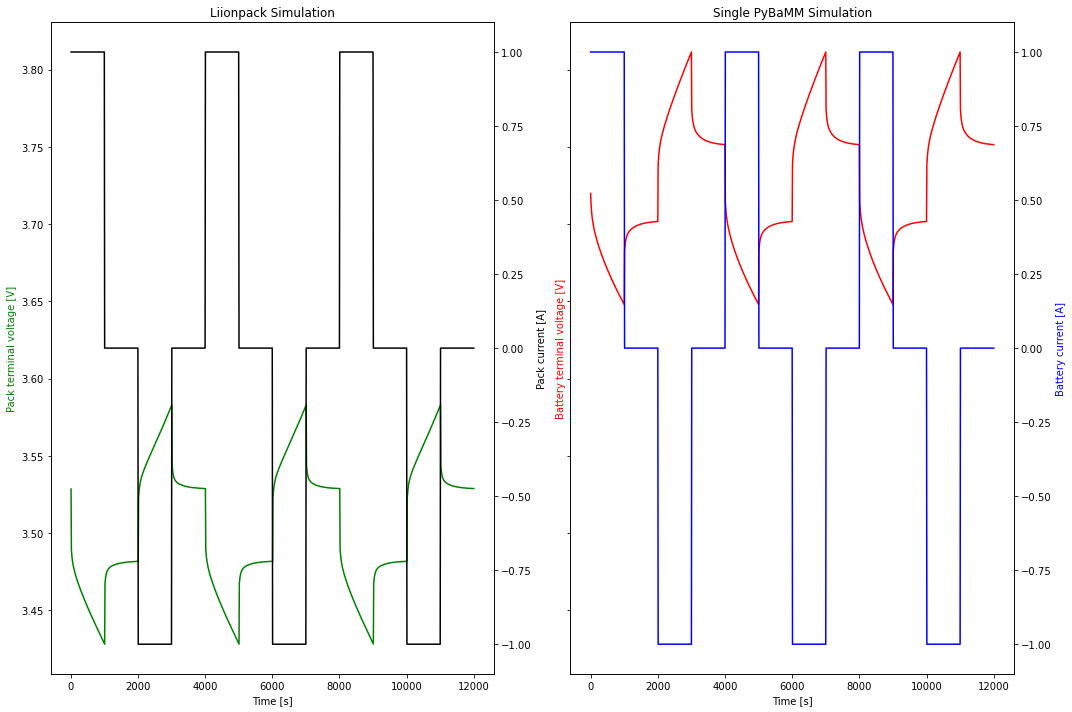

In [14]:
compare(sol, output)

Here we are still comparing to the PyBaMM simulation at 0.5 SoC and we can see that liionpack started at a lower voltage corresponding to a lower SoC.

In [15]:
parameter_values = pybamm.ParameterValues(chemistry=chemistry)
parameter_values.update({"Total heat transfer coefficient [W.m-2.K-1]": 10.0})
sim = lp.create_simulation(parameter_values, experiment, make_inputs=False)
sol = sim.solve(initial_soc=SoC)

Now we can re-run the PyBaMM simulation and compare again

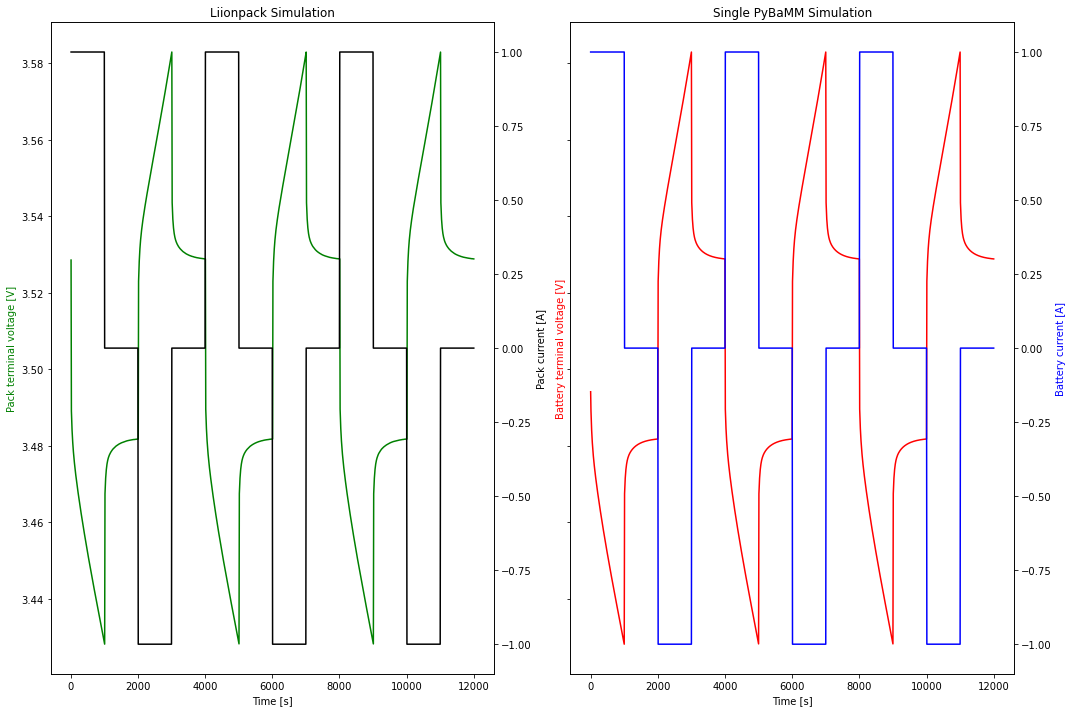

In [16]:
compare(sol, output)

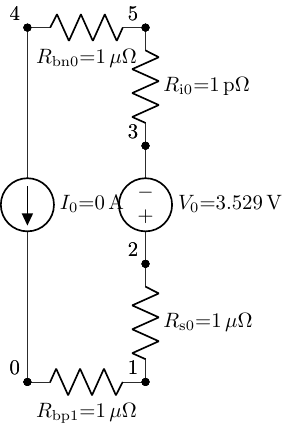

In [17]:
lp.draw_circuit(netlist)